In [28]:
import tensorflow as tf

In [2]:
tf.version.VERSION

'2.3.0'

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

In [4]:
# install kaggle api
!pip install kaggle

In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [7]:
!cd /content/drive/MyDrive/kaggle

In [8]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 88% 30.0M/34.1M [00:02<00:00, 5.25MB/s]
100% 34.1M/34.1M [00:02<00:00, 14.8MB/s]


In [9]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [10]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.3.0


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 100

# Data Loading

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [17]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Alzheimer_s Dataset/train/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [18]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

# Visualization

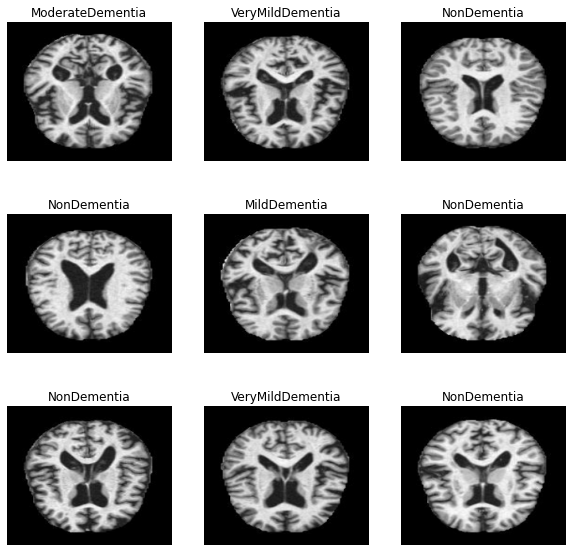

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [20]:
# Categorical values to onehot encodings
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [22]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "/content/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [25]:
NUM_IMAGES

[717, 52, 2560, 1792]

# Class Imbalance
**We have class imbalance so, Accuracy is not appropriate measure of validation, we will use ROC AUC curve for now. Near 1 results for ROC AUC are ideal.**

In [26]:
'''
Logic for class balancing goes here
'''

'\nLogic for class balancing goes here\n'

# Model Definition
Resnet-50 : https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50





In [30]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [38]:
with strategy.scope():
    model = ResNet50(weights=None, classes=4, input_shape=(176,208,3))
    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [39]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [40]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/100
257/257 [==============================] - 26s 102ms/step - loss: 1.5686 - auc: 0.7683 - val_loss: 31.4790 - val_auc: 0.6708
Epoch 2/100
257/257 [==============================] - 25s 97ms/step - loss: 0.9969 - auc: 0.8019 - val_loss: 1.1480 - val_auc: 0.6148
Epoch 3/100
257/257 [==============================] - 23s 91ms/step - loss: 0.9461 - auc: 0.8223 - val_loss: 1.2153 - val_auc: 0.6120
Epoch 4/100
257/257 [==============================] - 23s 91ms/step - loss: 0.9162 - auc: 0.8356 - val_loss: 1.2301 - val_auc: 0.6120
Epoch 5/100
257/257 [==============================] - 23s 91ms/step - loss: 0.9495 - auc: 0.8234 - val_loss: 1.2426 - val_auc: 0.6223
Epoch 6/100
257/257 [==============================] - 23s 91ms/step - loss: 0.9571 - auc: 0.8177 - val_loss: 4.4470 - val_auc: 0.6985
Epoch 7/100
257/257 [==============================] - 23s 91ms/step - loss: 0.9071 - auc: 0.8391 - val_loss: 7.4977 - val_auc: 0.6727
Epoch 8/100
257/257 [==============================] 

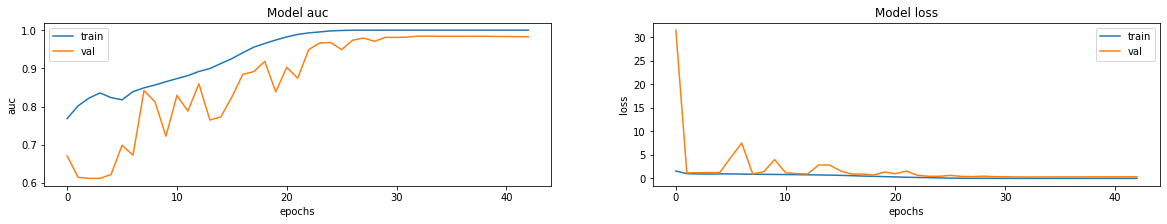

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])